# Gradient Boosting - Lab

## Introduction

In this lab, we'll learn how to use both Adaboost and Gradient Boosting Classifiers from scikit-learn!

## Objectives

You will be able to:

* Compare and contrast Adaboost and Gradient Boosting
* Use adaboost to make predictions on a dataset
* Use Gradient Boosting to make predictions on a dataset

## Getting Started

In this lab, we'll learn how to use Boosting algorithms to make classifications on the [Pima Indians Dataset](http://ftp.ics.uci.edu/pub/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names). You will find the data stored within the file `pima-indians-diabetes.csv`. Our goal is to use boosting algorithms to classify each person as having or not having diabetes. Let's get started!

We'll begin by importing everything we need for this lab. In the cell below:

* Import `numpy`, `pandas`, and `matplotlib.pyplot`, and set the standard alias for each. Also set matplotlib visualizations to display inline. 
* Set a random seed of `0` by using `np.random.seed(0)`
* Import `train_test_split` and `cross_val_score` from `sklearn.model_selection`
* Import `StandardScaler` from `sklearn.preprocessing`
* Import `AdaboostClassifier` and `GradientBoostingClassifier` from `sklearn.ensemble`
* Import `accuracy_score`, `f1_score`, `confusion_matrix`, and `classification_report` from `sklearn.metrics`

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

%matplotlib inline
np.random.seed(0)
# Define Performance Metrics Needed By tune_params_trees
def performance_r2_mse(y_true, y_pred):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen.
        Called if tune_params_trees is given 'r2_mse' """
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error as mse
    
    r2 = r2_score(y_true,y_pred)
    MSE = mse(y_true,y_pred)    
    return r2, MSE

# def performance_roc_auc(X_test,y_test,dtc,verbose=False):
def performance_roc_auc(y_true,y_pred):
    """Tests the results of an already-fit classifer. 
    Takes y_true (test split), and y_pred (model.predict()), returns the AUC for the roc_curve as a %.
    Called if tune_params_trees is given 'roc_auc' """
    FP_rate, TP_rate, thresh = roc_curve(y_test,y_pred)
    roc_auc = auc(FP_rate,TP_rate)
    roc_auc_perc = round(roc_auc*100,3)
    return roc_auc_perc


# DecisionTreeObject = DecisionTreeRegressor(random_state=45)
def tune_params_trees(param_name, param_values, DecisionTreeObject, perform_metric='r2_mse'):
    '''Takes a parame_name (str), param_values (list/array), a DecisionTreeObject, and a perform_metric.
    Loops through the param_values and re-fits the model and saves performance metrics. Displays color-mapped dataframe of results and line graph.
    
    Perform_metric can be 'r2_mse' or 'roc_auc'.
    Returns:
    - df of results
    - styled-df'''
    
    # Create results depending on performance metric
    if perform_metric=='r2_mse':
        results = [['param_name','param_value','r2_test','MSE_test']]
        
    elif perform_metric=='roc_auc':
        results =  [['param_name','param_value','roc_auc_test']]
    print(f'Using performance metrics: {perform_metric}')
    
    # Rename Deicision Tree for looping
    dtr_tune =  DecisionTreeObject
    
    # Loop through each param_value
    for value in param_values:

        # Set the parameters and fit the model
        dtr_tune.set_params(**{param_name:value})
        dtr_tune.fit(X_train,y_train)

        # Get predicitons and test_performance
        y_preds = dtr_tune.predict(X_test)
        
        # Perform correct performance metric and append results
        if perform_metric=='r2_mse':
            
            r2_test, mse_test = performance_r2_mse(y_test,y_preds)
            results.append([param_name,value,r2_test,mse_test])
        
        elif perform_metric=='roc_auc':
            
            roc_auc_test = performance_roc_auc(y_test,y_preds)
            results.append([param_name,value,roc_auc_test])
     

    # Convert results to dataframe, set index
    df_results = list2df(results);
    df_results.set_index('param_value',inplace=True)


    # Plot the values in results
    df_results.plot(subplots=True,sharex=True)

    # Style dataframe for easy visualization
    import seaborn as sns
    cm = sns.light_palette("green", as_cmap=True)
    df_style = df_results.style.background_gradient(cmap=cm,subset=['r2_test','MSE_test'])#,low=results.min(),high=results.max())
    # Display styled dataframe
    from IPython.display import display  
    display(df_style)
    
    return df_results

def list2df(list):#, sort_values='index'):
    """ Take in a list where row[0] = column_names and outputs a dataframe.
    
    Keyword arguments:
    set_index -- df.set_index(set_index)
    sortby -- df.sorted()
    """    
    
    df_list = pd.DataFrame(list[1:],columns=list[0])
#     df_list = df_list[1:]

    return df_list
def scale_data(data, method='minmax', log=False):
    
    """Takes df or Series, scales it using desired method and returns scaled df.
    
    Parameters
    -----------
    data : pd.Series or pd.DataFrame
        entire dataframe of series to be scaled
    method : str
        The method for scaling to be implemented(default is 'minmax').
        Other options are 'standard' or 'robust'.
    log : bool, optional
        Takes log of data if set to True(deafault is False).
        
    Returns
    --------
    pd.DataFrame of scaled data.
    """
    
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
    
    scale = np.array(data)
    
    # reshape if needed
    if len(scale.shape) == 1:
        scale = scale.reshape(-1,1)
        
    # takes log if log=True  
    if log == True:
        scale = np.log(scale)
        
        
    # creates chosen scaler instance
    if method == 'robust':
        scaler = RobustScaler()
        
    elif method == 'standard':
        scaler = StandardScaler()
        
    else:
        scaler = MinMaxScaler()   
    scaled = scaler.fit_transform(scale)
    
    
    # reshape and create output DataFrame
    if  scaled.shape[1] > 1:
        df_scaled = pd.DataFrame(scaled, index=data.index, columns=data.columns)
        
    else:
        scaled = np.squeeze(scaled)
        scaled = pd.Series(scaled, name=data.name) 
        df_scaled = pd.DataFrame(scaled, index=data.index)
        
    return df_scaled

Now, use pandas to read in the data stored in `pima-indians-diabetes.csv` and store it in a DataFrame. Display the head to inspect the data we've imported and ensure everything loaded correctly. 

In [25]:
df = pd.read_csv('pima-indians-diabetes.csv')
display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Cleaning, Exploration, and Preprocessing

The target we're trying to predict is the `'Outcome'` column. A `1` denotes a patient with diabetes. 

By now, you're quite familiar with exploring and preprocessing a dataset, so we won't hold your hand for this step. 

In the following cells:

* Store our target column in a separate variable and remove it from the dataset
* Check for null values and deal with them as you see fit (if any exist)
* Check the distribution of our target
* Scale the dataset
* Split the dataset into training and testing sets, with a `test_size` of `0.25`

In [26]:
target = df.Outcome
df.drop('Outcome', inplace=True, axis=1)


In [27]:
display(df.isna().sum())
df.describe()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


/Users/michaelmoravetz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


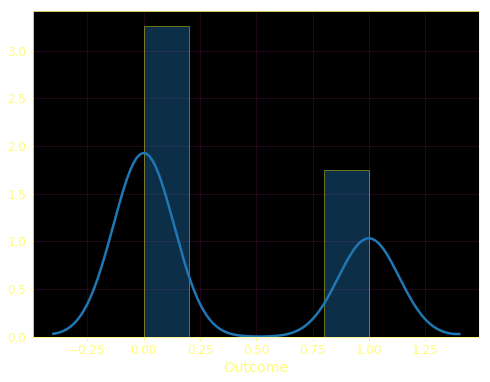

In [28]:
plt.style.use('dark_backm')
plt.figure(figsize=(8,6))
sns.distplot(target)
plt.show()

In [29]:
scaled_df = scale_data(df)
scaled_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000


In [30]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=.25)

## Training the Models

Now that we've cleaned and preprocessed our dataset, we're ready to fit some models!

In the cell below:

* Create an `AdaBoostClassifier`
* Create a `GradientBoostingClassifer`

In [31]:
adaboost_clf = AdaBoostClassifier()
gbt_clf = GradientBoostingClassifier()

Now, train each of the classifiers using the training data.

In [32]:
ada_clf = adaboost_clf.fit(X_train, y_train)

In [33]:
grd_clf = gbt_clf.fit(X_train, y_train)

Now, let's create some predictions using each model so that we can calculate the training and testing accuracy for each.

In [34]:
adaboost_train_preds = ada_clf.predict(X_train)
adaboost_test_preds = ada_clf.predict(X_test)
gbt_clf_train_preds = grd_clf.predict(X_train)
gbt_clf_test_preds = grd_clf.predict(X_test)

Now, complete the following function and use it to calculate the training and testing accuracy and f1-score for each model. 

In [35]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print(f"Model: {model_name}")
    print(f"Accuracy: {acc}")
    print(f"F1-Score: {f1}")
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.8229166666666666
F1-Score: 0.7424242424242425

Model: Gradient Boosted Trees
Accuracy: 0.9322916666666666
F1-Score: 0.9007633587786259

Testing Metrics
Model: AdaBoost
Accuracy: 0.7916666666666666
F1-Score: 0.6666666666666667

Model: Gradient Boosted Trees
Accuracy: 0.8125
F1-Score: 0.6727272727272728


Let's go one step further and create a confusion matrix and classification report for each. Do so in the cell below.

In [36]:
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

array([[112,  18],
       [ 22,  40]])

In [37]:
gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
gbt_confusion_matrix

array([[119,  11],
       [ 25,  37]])

In [38]:
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       130
           1       0.69      0.65      0.67        62

   micro avg       0.79      0.79      0.79       192
   macro avg       0.76      0.75      0.76       192
weighted avg       0.79      0.79      0.79       192



In [39]:
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       130
           1       0.77      0.60      0.67        62

   micro avg       0.81      0.81      0.81       192
   macro avg       0.80      0.76      0.77       192
weighted avg       0.81      0.81      0.81       192



**_Question:_** How did the models perform? Interpret the evaluation metrics above to answer this question.

Write your answer below this line:
_______________________________________________________________________________________________________________________________The models performed poorly but better than random guessing(by about 15%). adaboost, was accross the board about 66% for precision recall and f1, while gradientboostclasifier was remarkdably better in its precision score of 77% while recall was low.... 

 
 
As a final performance check, let's calculate the `cross_val_score` for each model! Do so now in the cells below. 

Recall that to compute the cross validation score, we need to pass in:

* a classifier
* All training Data
* All labels
* The number of folds we want in our cross validation score. 

Since we're computing cross validation score, we'll want to pass in the entire (scaled) dataset, as well as all of the labels. We don't need to give it data that has been split into training and testing sets because it will handle this step during the cross validation. 

In the cells below, compute the mean cross validation score for each model. For the data, use our `scaled_df` variable. The corresponding labels are in the variable `target`. Also set `cv=5`.

In [40]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, scaled_df, target, cv=5).mean())
# Expected Output: 0.7631270690094218

Mean Adaboost Cross-Val Score (k=5):
0.7631270690094218


In [41]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, scaled_df, target, cv=5).mean())
# Expected Output: 0.7591715474068416

Mean GBT Cross-Val Score (k=5):
0.7604702487055428


These models didn't do poorly, but we could probably do a bit better by tuning some of the important parameters such as the **_Learning Rate_**. 

## Summary

In this lab, we learned how to use scikit-learn's implementations of popular boosting algorithms such as AdaBoost and Gradient Boosted Trees to make classification predictions on a real-world dataset!